<h2>Formula 1 Grand Prix status prediction</h2>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder ,RobustScaler
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV,train_test_split,KFold,GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor,RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pickle


plt.style.use('bmh')
pd.set_option('display.float_format', '{:.2f}'.format)

<h3>Data cleaning</h3>

In [3]:
results = pd.read_csv(r'data/results.csv')
races = pd.read_csv(r'data/races.csv')
drivers = pd.read_csv(r'data/drivers.csv')
constructors = pd.read_csv(r'data/constructors.csv')
circuits = pd.read_csv(r'data/circuits.csv')
status = pd.read_csv(r'data/status.csv')
laptimes = pd.read_csv(r'data/lap_times.csv')


countries = pd.read_csv(r'data/countries/countries.csv')

In [4]:
df1 = pd.merge(races,results,how='left',on=['raceId'], suffixes=('_race', '_result'))
df2 = pd.merge(df1,drivers,how='left',on=['driverId'], suffixes=('', '_driver'))
df3 = pd.merge(df2,constructors,how='left',on=['constructorId'], suffixes=('', '_constructor'))
df4 = pd.merge(df3,circuits,how='left',on=['circuitId'], suffixes=('', '_circuit'))
df5 = pd.merge(df4,status,how='left',on=['statusId'], suffixes=('', '_status'))

In [6]:

data = df5;
#drop the columns which are not important


data = data.drop(['raceId',  'round', 'circuitId', 'name', 'time_race',
       'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'resultId', 'constructorId', 'number',  'position',
       'positionText','positionOrder', 'points', 'time_result',
        'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'driverRef', 'number_driver',
       'code',   'url_driver',
       'constructorRef', 
       'url_constructor', 'circuitRef',  'location',
       'lat', 'lng', 'alt', 'url_circuit', 
      ],axis=1)

In [7]:
testData = data.copy()
#print test data where year = 2020 and name_circuit = 'Bahrain International Circuit'
testData.columns
#export test data to csv
#testData.to_csv('testData.csv', index=False)


Index(['year', 'date', 'weather', 'driverId', 'grid', 'laps', 'milliseconds',
       'forename', 'surname', 'dob', 'nationality', 'name_constructor',
       'nationality_constructor', 'name_circuit', 'country', 'type', 'status'],
      dtype='object')

In [8]:
#rename the columns
data.rename(columns={'name':'race_name','grid':'qualification_pos','name_constructor':'constructor',
                     'nationality':'driver_nationality','nationality_constructor':'constructor_nationality', 'name_circuit' :'circuit', 'country': 'country_circuit', 'type': 'type_circuit', 'dob':'driver_date_of_birth'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
#drop forename columns and surname columns
data = data.drop(['forename','surname'],axis=1)
def convert_to_full_date(date_str):
    day, month, year = date_str.split('-')
    year = int(year)
    # Assume years < 50 are in 2000s, otherwise in 1900s
    full_year = 2000 + year if year < 50 else 1900 + year
    return f"{day}-{month}-{full_year}"
# Specify the date format explicitly
data['full_date'] = data['date'].apply(convert_to_full_date)
data['driver_date_of_birth'] = pd.to_datetime(data['driver_date_of_birth'])
data['date'] = pd.to_datetime(data['full_date'], format='%d-%m-%Y')
data = data.drop(['full_date'],axis=1)

#get month and day from date into new columns
data['race_month'] = data['date'].dt.month
data['race_day'] = data['date'].dt.day
data.rename(columns={'year':'race_year'},inplace=True)


In [9]:
data['age_at_gp_in_days'] = abs(data['driver_date_of_birth']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0]).astype(int)

first_race_dates = data.groupby('driverId')['date'].min().reset_index()
first_race_dates.rename(columns={'date': 'first_race_date'}, inplace=True)
data = data.merge(first_race_dates, on='driverId', how='left')
data = data.drop(['driverId'],axis=1)

data['days_since_first_race'] = abs(data['first_race_date']-data['date'])
data['days_since_first_race'] = data['days_since_first_race'].apply(lambda x: str(x).split(' ')[0]).astype(int)

In [10]:
#create a rain column where if the weather is 'Rain or 'Changeable' or 'Very changeable' then 1 else 0
data['rain'] = data['weather'].apply(lambda x: 1 if x in ['Rain', 'Changeable', 'Very changeable'] else 0)
#drop the weather column
data = data.drop(['weather'],axis=1)

In [11]:
#select all data from 1980
data = data[data['race_year']>=1981]
#get first nationality only


In [12]:
print(data.columns)

Index(['race_year', 'date', 'qualification_pos', 'laps', 'milliseconds',
       'driver_date_of_birth', 'driver_nationality', 'constructor',
       'constructor_nationality', 'circuit', 'country_circuit', 'type_circuit',
       'status', 'driver', 'race_month', 'race_day', 'age_at_gp_in_days',
       'first_race_date', 'days_since_first_race', 'rain'],
      dtype='object')


In [13]:
#get all unique constructors
constructors = data['constructor'].unique()
print('All Constructors:')
print(constructors)

All Constructors:
['Williams' 'Brabham' 'Alfa Romeo' 'Tyrrell' 'Theodore' 'Fittipaldi'
 'Renault' 'Ensign' 'Ferrari' 'Ligier' 'ATS' 'Arrows' 'Osella'
 'Team Lotus' 'McLaren' 'March' 'Toleman' 'RAM' 'Spirit' 'Minardi'
 'Zakspeed' 'Lola' 'Benetton' 'AGS' 'Larrousse' 'Coloni' 'Rial'
 'Euro Brun' 'Dallara' 'Onyx' 'Leyton House' 'Life' 'Lambo' 'Jordan'
 'Footwork' 'Fondmetal' 'Andrea Moda' 'Sauber' 'Simtek' 'Pacific' 'Forti'
 'Prost' 'Stewart' 'BAR' 'Jaguar' 'Toyota' 'Red Bull' 'Honda' 'Toro Rosso'
 'BMW Sauber' 'MF1' 'Super Aguri' 'Spyker MF1' 'Spyker' 'Force India'
 'Brawn' 'Mercedes' 'Lotus' 'HRT' 'Virgin' 'Lotus F1' 'Marussia'
 'Caterham' 'Manor Marussia' 'Haas F1 Team' 'Racing Point' 'AlphaTauri'
 'Aston Martin' 'Alpine F1 Team' 'RB F1 Team']


In [14]:
data['constructor_nationality'].unique()


array(['British', 'Swiss', 'Hong Kong', 'Brazilian', 'French', 'Italian',
       'German', 'Irish', 'Japanese', 'Austrian', 'Russian', 'Dutch',
       'Indian', 'Malaysian', 'Spanish', 'American'], dtype=object)

In [15]:
#clean data
data['driver_nationality'] = data['driver_nationality'].replace('Argentinian', 'Argentine')
data['country_circuit'] = data['country_circuit'].replace('United States', 'USA')

In [16]:
#for country circuit

#Change all "Argentinian" to "Argentine"
data_tmp = data.copy()

#get first nationality only
df_countries = countries.copy()
df_countries['nationality'] = df_countries['nationality'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: x.split(',')[0].strip())
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UK' if x=='United Kingdom of Great Britain and Northern Ireland' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'UAE' if x=='United Arab Emirates' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Korea' if x=='Korea (Republic of)' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'Russia' if x=='Russian Federation' else x)
df_countries['en_short_name'] = df_countries['en_short_name'].apply(lambda x: 'USA' if x=='United States of America' else x)

#drop rows with duplicate nationality
df_countries = df_countries[df_countries['en_short_name'] != 'Taiwan']
df_countries = df_countries[df_countries['en_short_name'] != 'United States Minor Outlying Islands']


data_with_circuit_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='country_circuit', 
    right_on='en_short_name'  
)

#en_short_name

data_with_circuit_nationality=data_with_circuit_nationality.drop(['country_circuit', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_circuit_nationality.rename(columns={'alpha_3_code':'circuit_nationality'}, inplace=True)


In [17]:
data_tmp = data_with_circuit_nationality.copy()

data_with_driver_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='driver_nationality', 
    right_on='nationality'  
)

data_with_driver_nationality=data_with_driver_nationality.drop(['driver_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_driver_nationality.rename(columns={'alpha_3_code':'driver_nationality'}, inplace=True)



In [18]:
data_tmp = data_with_driver_nationality.copy()

data_with_constructor_nationality = data_tmp.merge(
    df_countries,
    how='left',
    left_on='constructor_nationality', 
    right_on='nationality'  
)
data_with_constructor_nationality=data_with_constructor_nationality.drop(['constructor_nationality', 'num_code', 'alpha_2_code', 'en_short_name', 'nationality'], axis=1)
data_with_constructor_nationality.rename(columns={'alpha_3_code':'constructor_nationality'}, inplace=True)


In [19]:
#data after processing nationalities
data = data_with_constructor_nationality;
data['driver_home'] = data['driver_nationality'] == data['circuit_nationality']
data['constructor_home'] = data['constructor_nationality'] == data['circuit_nationality']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))


In [21]:
#create a dnf column
# pattern = r"\+.* Lap.*"
# data_median = data_median[data_median['status'].eq('Finished') | data_median['status'].str.match(pattern)]
#dnf = 0 if status = 'Finished' or match regex else 1
pattern = r"\+.* Lap.*"
data['dnf'] = data['status'].apply(lambda x: 0 if x == 'Finished' or re.match(pattern, x) else 1)
data.drop(['status'], axis=1, inplace=True)
data.drop_duplicates(inplace=True)
data


,race_year,date,qualification_pos,laps,milliseconds,driver_date_of_birth,constructor,circuit,type_circuit,driver,...,age_at_gp_in_days,first_race_date,days_since_first_race,rain,circuit_nationality,driver_nationality,constructor_nationality,driver_home,constructor_home,dnf
0,1981,1981-03-15,2,80,6641330,1946-11-02,Williams,Long Beach,Street circuit,Alan Jones,...,12552,1975-04-27,2149,0,USA,AUS,GBR,0,0,0
1,1981,1981-03-15,3,80,6650520,1942-04-12,Williams,Long Beach,Street circuit,Carlos Reutemann,...,14217,1972-01-23,3339,0,USA,ARG,GBR,0,0,0
2,1981,1981-03-15,4,80,6676250,1952-08-17,Brabham,Long Beach,Street circuit,Nelson Piquet,...,10437,1978-07-30,959,0,USA,BRA,GBR,0,0,0
3,1981,1981-03-15,6,80,6690640,1940-02-28,Alfa Romeo,Long Beach,Street circuit,Mario Andretti,...,14991,1968-10-06,4543,0,USA,USA,CHE,1,0,0
4,1981,1981-03-15,8,80,6708030,1958-01-10,Tyrrell,Long Beach,Street circuit,Eddie Cheever,...,8465,1978-01-15,1155,0,USA,USA,GBR,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18444,2024,2024-12-08,14,57,\N,1992-10-05,Haas F1 Team,Yas Marina Circuit,Race circuit,Kevin Magnussen,...,11752,2014-03-16,3920,0,ARE,DNK,USA,0,0,0
18445,2024,2024-12-08,12,55,\N,2002-02-11,RB F1 Team,Yas Marina Circuit,Race circuit,Liam Lawson,...,8336,2023-08-27,469,0,ARE,NZL,ITA,0,0,1
18446,2024,2024-12-08,9,30,\N,1989-08-28,Sauber,Yas Marina Circuit,Race circuit,Valtteri Bottas,...,12886,2013-03-17,4284,0,ARE,FIN,CHE,0,0,1
18447,2024,2024-12-08,20,26,\N,2003-05-27,Williams,Yas Marina Circuit,Race circuit,Franco Colapinto,...,7866,2024-09-01,98,0,ARE,ARG,GBR,0,0,1


<h3>Testing different models on cleaned data (For main race)</h3>

In [28]:
# Drop irrelevant columns
columns_to_drop = [ 'driver_date_of_birth', 'date', 'first_race_date',
                   'milliseconds', 'laps']


cleaned_data = data.drop(columns=columns_to_drop)
cleaned_data.rename(columns={'qualification_pos':'qualification_position'},inplace=True)
cleaned_data.drop_duplicates(inplace=True)
cleaned_data.dtypes
#export cleaned data to csv


race_year                   int64
qualification_position      int64
constructor                object
circuit                    object
type_circuit               object
driver                     object
race_month                  int32
race_day                    int32
age_at_gp_in_days           int32
days_since_first_race       int32
rain                        int64
circuit_nationality        object
driver_nationality         object
constructor_nationality    object
driver_home                 int64
constructor_home            int64
dnf                         int64
dtype: object

In [29]:
cleaned_data.to_csv('cleaned_status_data.csv', index=False)

In [30]:
# Split features and target
y = cleaned_data['dnf']
X = cleaned_data.drop(columns=['dnf'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [31]:
#evalation functions

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    return y_pred, y_proba



In [32]:

robust_cols = ['qualification_position', 'age_at_gp_in_days', 'days_since_first_race']
cat_cols = ['constructor','circuit','type_circuit','driver','circuit_nationality','driver_nationality','constructor_nationality']
other_cols = ['race_year','race_month','race_day','rain', 'driver_home', 'constructor_home']


<h3> Random forest classifier</h3>

In [34]:
preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('models', RandomForestClassifier(random_state=42))
])

# Hyperparameter grid

param_grid = {
    'model__max_depth': [30],
    'model__min_samples_leaf': [ 4],
    'model__min_samples_split': [10],
    'model__n_estimators': [ 800]
}
# param_grid = {
#     'model__max_depth': [30],
#     'model__min_samples_leaf': [2, 3, 4],
#     'model__min_samples_split': [10, 15],
#     'model__n_estimators': [600, 800]
# }
# 
# Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 800}

# Cross-validation strategy
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Grid search with classification scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc', 
    verbose=1,
    n_jobs=-1
)

# Train models
grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC AUC Score (CV): {grid_search.best_score_:.4f}")

# Final models
best_model_rf = grid_search.best_estimator_

# Predict on test set
evaluate_model(best_model_rf, X_test, y_test)




Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 800}
Best ROC AUC Score (CV): 0.7668

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      2295
           1       0.62      0.52      0.56      1395

    accuracy                           0.70      3690
   macro avg       0.68      0.66      0.67      3690
weighted avg       0.69      0.70      0.69      3690

Confusion Matrix:
[[1852  443]
 [ 676  719]]
ROC AUC Score: 0.7469


(array([1, 0, 1, ..., 0, 1, 0], dtype=int64),
 array([0.89051257, 0.47122847, 0.59841994, ..., 0.17121957, 0.5754533 ,
        0.22289052]))

C:\Users\Admin\AppData\Local\Temp\ipykernel_29804\1648476756.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


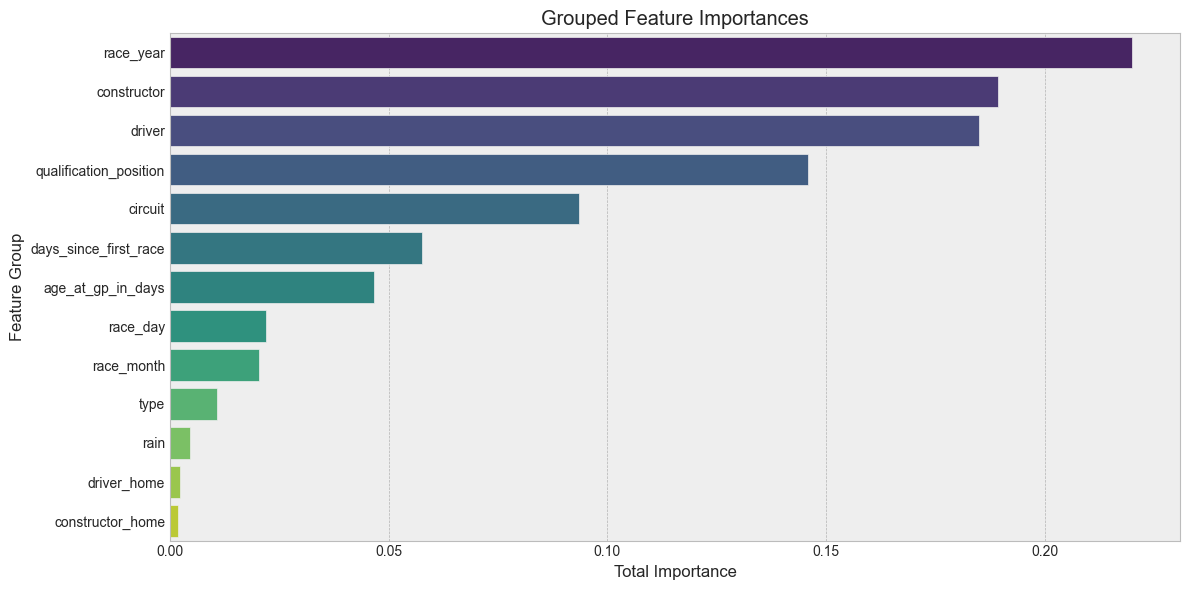

In [36]:
# Get best pipeline from grid search
best_pipeline = best_model_rf

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Grouped Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

In [37]:
# save
with open('rf_status.pkl','wb') as f:
    pickle.dump(best_model_rf,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)


In [38]:

failure_probs = best_model_rf.predict_proba(X_test)[:, 1]
failure_probs

array([0.89051257, 0.47122847, 0.59841994, ..., 0.17121957, 0.5754533 ,
       0.22289052])

<h5>Gradient boost Classifier</h5>

In [39]:
# Split features and target
preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('models', GradientBoostingClassifier(verbose=1))
])

# GridSearchCV parameters (nested under "model__")
param_grid = {
    'model__loss': [ 'log_loss'],
    'model__learning_rate': [0.01],
    'model__n_estimators': [ 400],
    'model__min_samples_split': [  15],
    'model__min_samples_leaf': [ 5],
    'model__max_depth': [ 5],
}
# param_grid = {
#     'model__loss': [ 'log_loss', 'exponential'],
#     'model__learning_rate': [0.01, 0.1],
#     'model__n_estimators': [ 300, 400],
#     'model__min_samples_split': [ 10, 15],
#     'model__min_samples_leaf': [ 4, 5],
#     'model__max_depth': [ 4, 5],
# }

# Cross-validation strategy
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Grid search with classification scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc', 
    verbose=1,
    n_jobs=-1
)

# Train models
grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC AUC Score (CV): {grid_search.best_score_:.4f}")

# Final models
best_model_gb = grid_search.best_estimator_

# Predict on test set
evaluate_model(best_model_gb, X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
      Iter       Train Loss   Remaining Time 
         1           1.3345            1.02m
         2           1.3302            1.02m
         3           1.3261            1.01m
         4           1.3220            1.00m
         5           1.3180            1.02m
         6           1.3140            1.04m
         7           1.3102            1.06m
         8           1.3064            1.07m
         9           1.3027            1.08m
        10           1.2991            1.09m
        20           1.2663            1.02m
        30           1.2391           58.40s
        40           1.2161           56.97s
        50           1.1966           55.34s
        60           1.1799           53.29s
        70           1.1654           51.80s
        80           1.1530           50.55s
        90           1.1422           49.03s
       100           1.1327           47.27s
       200           1.0787           31

(array([1, 0, 1, ..., 0, 1, 0], dtype=int64),
 array([0.96690288, 0.47462924, 0.59608526, ..., 0.20426756, 0.60018851,
        0.27360268]))

C:\Users\Admin\AppData\Local\Temp\ipykernel_29804\285344360.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


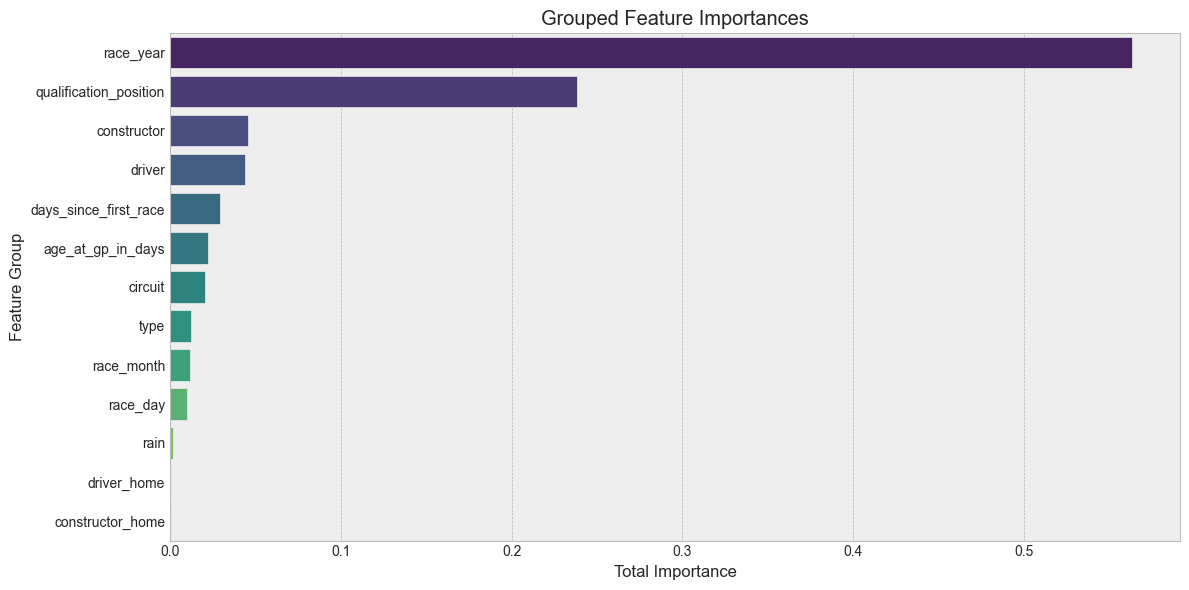

In [40]:
# Get best pipeline from grid search
best_pipeline = best_model_gb

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name
    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Grouped Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

In [42]:
# save
with open('gb_status.pkl','wb') as f:
    pickle.dump(best_model_gb,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

<h3>Logistic Regression</h3>

In [43]:
preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')


# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('models', LogisticRegression(verbose=1))
])

# GridSearchCV parameters (nested under "model__")
param_grid = {
    'model__C': [0.1,],
    'model__penalty': ['l2'],
    'model__solver': ['liblinear'],
    'model__max_iter': [100]
}
# param_grid = {
#     'model__C': [0.1, 1.0, 10.0],
#     'model__penalty': ['l2','l1'],
#     'model__solver': ['lbfgs','liblinear'],
#     'model__max_iter': [100,200,300]
# }

#[LibLinear]Best Parameters: {'model__C': 0.1, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
# Cross-validation strategy
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Grid search with classification scoring
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Train models
grid_search.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print(f"Best ROC AUC Score (CV): {grid_search.best_score_:.4f}")

# Final models
best_model_lg = grid_search.best_estimator_

# Predict on test set
evaluate_model(best_model_lg, X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear]Best Parameters: {'model__C': 0.1, 'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best ROC AUC Score (CV): 0.7484

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76      2295
           1       0.61      0.51      0.55      1395

    accuracy                           0.69      3690
   macro avg       0.67      0.66      0.66      3690
weighted avg       0.68      0.69      0.68      3690

Confusion Matrix:
[[1841  454]
 [ 686  709]]
ROC AUC Score: 0.7279


(array([1, 1, 1, ..., 0, 1, 0], dtype=int64),
 array([0.78877156, 0.539184  , 0.67186206, ..., 0.20937372, 0.54421134,
        0.20498674]))

In [44]:
# save
with open('lg_status.pkl','wb') as f:
    pickle.dump(best_model_lg,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

In [3]:
#one hot encoding example for a single column of driver with 3 values
df = pd.DataFrame({'driver': ['Lewis', 'Max', 'Oscar']})
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[['driver']])
encoded = ohe.transform(df[['driver']])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(['driver']))
#print 2 dataframes to visual graph
print("Original DataFrame:")
print(df)
print("\nOne-Hot Encoded DataFrame:")

Original DataFrame:
  driver
0  Lewis
1    Max
2  Oscar

One-Hot Encoded DataFrame:
   driver_Lewis  driver_Max  driver_Oscar
0          1.00        0.00          0.00
1          0.00        1.00          0.00
2          0.00        0.00          1.00
